# Snowflake Machine Learning

Steps:
1. Preview Data and EDA
2. Preprocessing
3. Causal Modeling
4. Ad Targeting Modelings

Note: 
This notebook analysis is on synthetic data


In [97]:
from IPython.display import display, HTML, Image , Markdown
from snowflake.snowpark.session import Session
import snowflake.snowpark.types as T
import snowflake.snowpark.functions as F
import os ,configparser ,json ,logging
import pandas as pd
import joblib
from causallib.estimation import IPW
from causallib.evaluation import evaluate
from matplotlib import pyplot as plt
from snowflake.snowpark.functions import udf
from snowflake.snowpark.functions import lit 
from sklearn.metrics import (
    ConfusionMatrixDisplay, 
    roc_auc_score, 
    average_precision_score, 
    precision_recall_curve, 
    roc_curve
)
from joblib import dump
import cachetools as ct
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import os
from joblib import dump
# Import the commonly defined utility scripts using
import sys
sys.path.append('..')
import sp4py_preprocessing as pp
import lutils.sflk_base as L
import boto3


display(Markdown("## Initialization"))
logging.basicConfig(stream=sys.stdout, level=logging.ERROR)

# Define the project home directory, this is used for locating the config.ini file
PROJECT_HOME_DIR = '../'
config = L.get_config(PROJECT_HOME_DIR)
session = L.connect_to_snowflake(PROJECT_HOME_DIR)
stage_location=f"@{config['SNOW_CONN']['staging']}" # staging will be used throughout

os.chdir('../')
if not os.path.isfile('data/customers.csv.gz'):
    s3 = boto3.client('s3',aws_access_key_id=config['AWS_S3']['access_key'] , aws_secret_access_key=config['AWS_S3']['secret_key'])
    s3.download_file(config['AWS_S3']['bucket'],config['AWS_S3']['file'],'data/customers.csv.gz')
os.chdir('notebook')

if(session == None):
   raise Exception(f'Unable to connect to snowflake. Validate connection information ')

setup = False # flag for first time setup
if setup:
    display(Markdown("### First Time Setup!"))
    display(Markdown("#### Creating Warehouse"))

    session.sql(f"""CREATE OR REPLACE WAREHOUSE 
    {config['SNOW_CONN']['warehouse']} 
    WITH WAREHOUSE_SIZE = 'MEDIUM'
    WAREHOUSE_TYPE = 'SNOWPARK-OPTIMIZED'""").collect()  

    display(Markdown("#### Creating Database"))
    session.sql(f"CREATE OR REPLACE DATABASE {config['SNOW_CONN']['database']}").collect()


    display(Markdown("#### Adding Customer Data Table"))
    df = pd.read_csv(os.path.join('..', config['DATA']['data_folder'], config['DATA']['data_file']))
    session.write_pandas(
        df, 
        table_name=config['SNOW_CONN']['data_table'], 
        auto_create_table=True, 
        overwrite=True
    )
    
else:
    session.use_role(f'''{config['SNOW_CONN']['role']}''')
    session.use_warehouse(f'''{config['SNOW_CONN']['warehouse']}''')
    session.use_schema(f'''{config['SNOW_CONN']['database']}.{config['SNOW_CONN']['schema']}''')

display(Markdown("### Session Info"))
df1 = session.sql('select current_user() ,current_role() ,current_database() ,current_schema();').to_pandas()
display(df1)

## Initialization

### Session Info

,CURRENT_USER(),CURRENT_ROLE(),CURRENT_DATABASE(),CURRENT_SCHEMA()
0,JPRUSA,SYSADMIN,ADS_DATA,PUBLIC


---
## 1. Preview Data and EDA

In [2]:
ad_df=session.table("CUSTOMER_DATA")
df=ad_df.to_pandas()

In [3]:
display(Markdown("#### Summary Statistics"))
display(df.describe())
# missing value check
display(Markdown("#### Missing value check"))
display(df.isna().sum())
display(Markdown("There are no missing values, so there is no need to drop or impute missing data."))


#### Summary Statistics

,HOUSEHOLD_INDEX,AGE_BAND,SAW_AD,PURCHASED,IS_CUSTOMER
count,5.915982e+06,5.915982e+06,5.915982e+06,5.915982e+06,5.915982e+06
mean,3.576671e+00,4.509432e+01,3.247562e-01,3.544380e-01,9.998310e-01
std,1.761236e+00,1.537609e+01,4.682837e-01,4.783427e-01,1.300020e-02
min,1.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,3.500000e+01,0.000000e+00,0.000000e+00,1.000000e+00
50%,4.000000e+00,4.500000e+01,0.000000e+00,0.000000e+00,1.000000e+00
75%,5.000000e+00,5.500000e+01,1.000000e+00,1.000000e+00,1.000000e+00
max,6.000000e+00,8.500000e+01,1.000000e+00,1.000000e+00,1.000000e+00


#### Missing value check

USER_ID            0
HOUSEHOLD_INDEX    0
AGE_BAND           0
MARITAL_STATUS     0
SAW_AD             0
PURCHASED          0
IS_CUSTOMER        0
dtype: int64

There are no missing values, so there is no need to drop or impute missing data.

In [4]:
# determine feature types. numeric, categorical, binary feature.

display(Markdown("#### determine feature types: numeric, categorical, binary"))
display(df.nunique())

display(Markdown('''
We have binary/categorical/ordinal features. Martital status is categorical. 
It is also safest to  treat HOUSEHOLD_INDEX as such since know the meaning or distance 
between values. Age is binned and thus ordinal, rather than numeric. we can also treat 
it at categorical everythin else is binary.
'''))


#### determine feature types: numeric, categorical, binary

USER_ID            3471167
HOUSEHOLD_INDEX          6
AGE_BAND                14
MARITAL_STATUS           4
SAW_AD                   2
PURCHASED                2
IS_CUSTOMER              2
dtype: int64


We have binary/categorical/ordinal features. Martital status is categorical. 
It is also safest to  treat HOUSEHOLD_INDEX as such since know the meaning or distance 
between values. Age is binned and thus ordinal, rather than numeric. we can also treat 
it at categorical everythin else is binary.


### Distributions of unique values for each feature

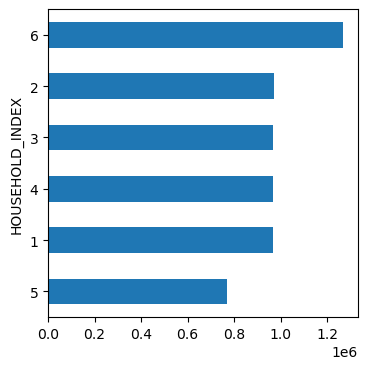

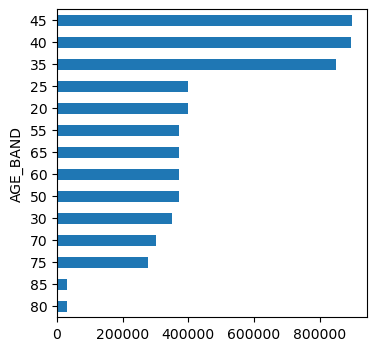

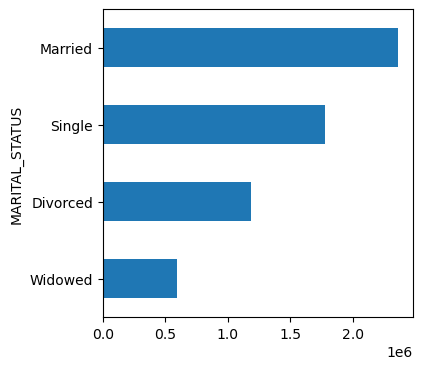

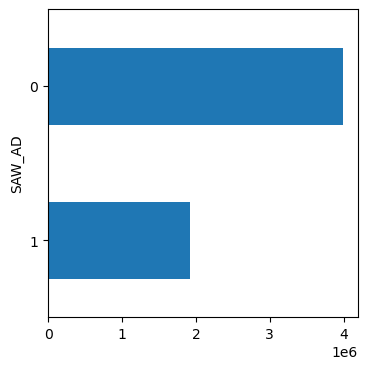

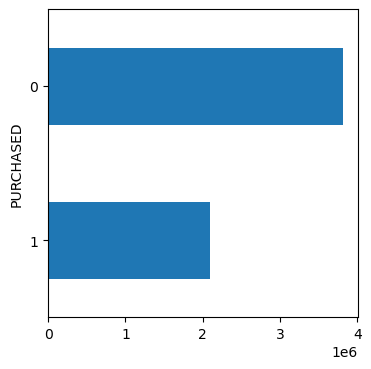

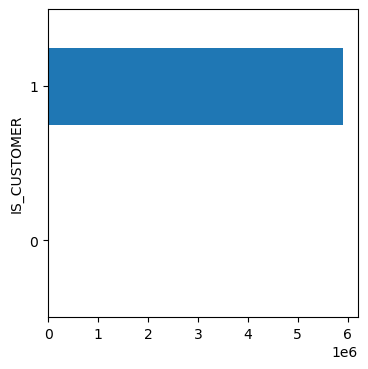

In [5]:
# we ignore ID for obvious reasons
for column in df.columns[1:]:
    var_analysis = df.groupby(column).count().iloc[:,0]
    var_analysis = var_analysis.sort_values()
    var_analysis.plot.barh(x=column, figsize=(4,4))
    plt.show();

### Fraction of each category within a column that purchased

Index(['HOUSEHOLD_INDEX', 'AGE_BAND', 'MARITAL_STATUS', 'SAW_AD'], dtype='object')


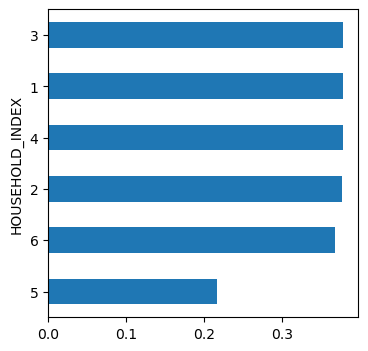

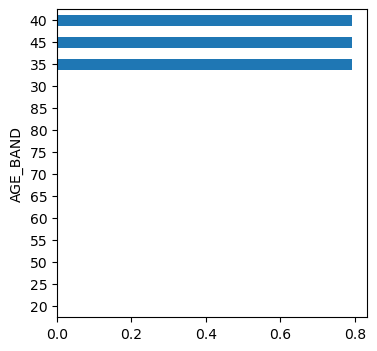

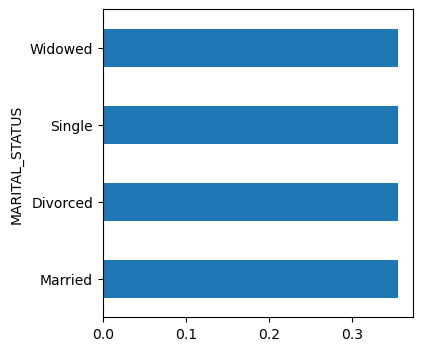

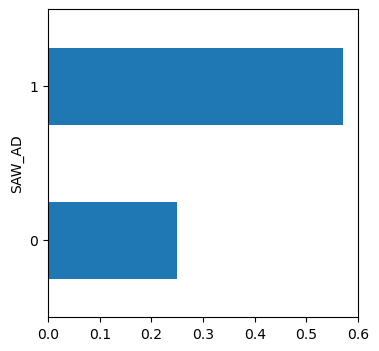

In [6]:
print(df.columns[1:-2])
for column in df.columns[1:-2]:
    var_analysis = df.groupby(column).mean()
    var_analysis = var_analysis.sort_values('PURCHASED')['PURCHASED']
    #var_analysis['FRAC_PURCHASED'] = var_analysis.FRAC_PURCHASED.astype('float')
    var_analysis.plot.barh(x=column, figsize=(4,4))
    plt.show();


---
## 2. Preprocessing
### Categorical Data Encoding

We need to encode our categorical columns HOUSEHOLD_INDEX and MARITIAL_STATUS to ensure compatibility with a wider range of ml algorithms (suvh as logistic regression. XGBoost/lgbm do not need this as can naitively handle categorical variables one hot encoding is used for its simplicity and the low number of categories and categorical variables present in our data. AGE_BAND can be treated as ordinal rather than categorical so we will test both approaches

In [7]:
# AGE_BAND as ordinal
one_hot_encoder = pp.OneHotEncoder(input_cols=['HOUSEHOLD_INDEX', 'MARITAL_STATUS'])
one_hot_encoder.fit(ad_df)
snowpark_df_ohe = one_hot_encoder.transform(ad_df)

# AGE_BAND as categorical
one_hot_encoder = pp.OneHotEncoder(input_cols=['HOUSEHOLD_INDEX', 'AGE_BAND', 'MARITAL_STATUS'])
one_hot_encoder.fit(ad_df)
snowpark_df_ohe_all = one_hot_encoder.transform(ad_df)

In [8]:
# add prepared table to our DB
snowpark_df_ohe.write.save_as_table(table_name='CUSTOMERS_OHE', mode='overwrite') # ageband numeric
snowpark_df_ohe_all.write.save_as_table(table_name='CUSTOMERS_OHE_ALL', mode='overwrite') # ageband categorical

---
## 3. Causal Modelings
### DoWhy
Let's experiment with the doWhy Python Package first.

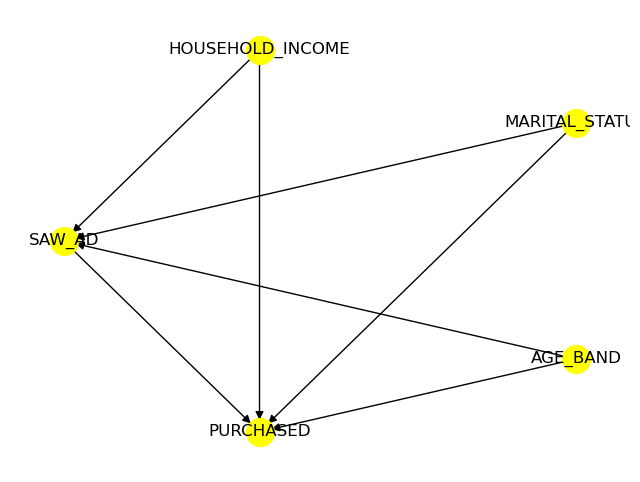

In [9]:
import matplotlib.pyplot as plt

import econml
from dowhy import CausalModel

treatment_feature = "SAW_AD"
outcome_feature = "PURCHASED"
common_causes_features = ["AGE_BAND","MARITAL_STATUS","HOUSEHOLD_INCOME"]

causal_model = CausalModel(
        data=df,
        treatment=treatment_feature,
        outcome=outcome_feature,
        common_causes=common_causes_features
        )

# View model
causal_model.view_model()
#from IPython.display import Image, display
#display(Image(filename="causal_model.png"))

### CausalLib (IPW)
Now, let's build the same using `CausalLib`:

In [10]:
snowpark_df_ohe = session.table('CUSTOMERS_OHE')
snowpark_df_ohe_all = session.table('CUSTOMERS_OHE_all')

# lets undersample to speed things up
snowpark_df_ohe_small = snowpark_df_ohe.randomSplit([.1,.9])[0] # throwing away 90% of data
snowpark_df_ohe_small.write.save_as_table(table_name='CUSTOMERS_OHE_SM', mode='overwrite')
snowpark_df_ohe_all_small = snowpark_df_ohe_all.randomSplit([.1,.9])[0] # throwing away 90% of data
snowpark_df_ohe_all_small.write.save_as_table(table_name='CUSTOMERS_OHE_ALL_SM', mode='overwrite')

In [11]:
# independent features, treatment and target variable for IPW
# we remove one category from each set of ohe values as it would have perfect 
# multicolinearity with the other columns for that feature
X = snowpark_df_ohe.drop(['USER_ID', 'SAW_AD', 'PURCHASED', 'IS_CUSTOMER', 'HOUSEHOLD_INDEX_6', 'MARITAL_STATUS_WIDOWED']).columns # independent variables
X_ = snowpark_df_ohe_all.drop(['USER_ID', 'SAW_AD', 'PURCHASED', 'IS_CUSTOMER', 'HOUSEHOLD_INDEX_6', 'MARITAL_STATUS_WIDOWED', 'AGE_BAND_85']).columns # independent variables AGE_BAND is categorical
a = 'SAW_AD' # treatment
y = 'PURCHASED' # target variable

In [ ]:
# create staging for ML models
session.sql(f"CREATE OR REPLACE STAGE {config['SNOW_CONN']['staging']}").collect()

# check our staging spaces
pd.DataFrame(session.sql('SHOW STAGES').collect())

#### IPW training sproc

In [15]:
def sproc_train_ipw_lr(session: Session, 
                       training_table: str, 
                       feature_cols: list,
                       treatment_col: str,
                       target_col: str,
                       model_names: list,
                       stage_location: str,) -> T.Variant:
    
    # Loading data into pandas dataframe
    local_training_data = session.table(training_table).to_pandas()
    # Define features, treatment and label dfs
    X = local_training_data[feature_cols]
    a = local_training_data[treatment_col]
    y = local_training_data[target_col]

    # Actual model training
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    import xgboost
    from xgboost import XGBClassifier
    from causallib.estimation import IPW
    from joblib import dump
    
    models = {
        model_names[0]: LogisticRegression(C=0.8, solver='lbfgs',random_state=0),
        model_names[1]: RandomForestClassifier(n_jobs=-1,random_state=0),
        model_names[2]: XGBClassifier(random_state=0)
    }
    
    output = {'model_name': [], 'outcomes': [], 'effect': []}
    for model_name, model in models.items():
        # fit ipw model
        ipw = IPW(model, clip_min=0.05)
        ipw.fit(X,a)
        

        # effect of treatment
        outcomes = ipw.estimate_population_outcome(X, a, y)
        output['outcomes'].append(list(outcomes.values))
        output['effect'].append(float(ipw.estimate_effect(outcomes[1], outcomes[0]).values))
        output['model_name'].append(model_name)
        
        # Save model as file and upload to Snowflake stage
        dump(ipw, '/tmp/'+model_name)
        session.file.put('/tmp/'+model_name, f'{stage_location}/ipw', auto_compress=False, overwrite=True)
        
    return output

# Registering the function as a Stored Procedure
import causallib
causallib_path = causallib.__path__[0]
sproc_train_ipw_lr = session.sproc.register(func=sproc_train_ipw_lr,
                                            name='sproc_train_lm_model', 
                                            is_permanent=True, 
                                            replace=True, 
                                            stage_location=stage_location, 
                                            imports = [(causallib_path, 'causallib')],
                                            packages=['snowflake-snowpark-python', 'statsmodels',
                                                          'scikit-learn','joblib', 'xgboost'])

In [16]:
training_table = 'CUSTOMERS_OHE_ALL'
model_name = ['logistic_reg_model_b.sav','random_forest_model_b.sav','xg_boost_model_b.sav']

output = sproc_train_ipw_lr(training_table, 
                            X_, 
                            a,
                            y,
                            model_name,
                            stage_location,
                            session=session)

training_table = 'CUSTOMERS_OHE'
model_name = ['logistic_reg_model.sav','random_forest_model.sav','xg_boost_model.sav']

output1 = sproc_train_ipw_lr(training_table, 
                             X, 
                             a,
                             y,
                             model_name,
                             stage_location,
                             session=session)
output = eval(output)
output1 = eval(output1)

In [17]:
frames=[pd.DataFrame(output), pd.DataFrame(output1)]
pd.concat(frames)

,effect,model_name,outcomes
0,0.284562,logistic_reg_model_b.sav,"[0.2859342372251388, 0.5704957644573463]"
1,0.334199,random_forest_model_b.sav,"[0.2965189507940546, 0.6307178274324302]"
2,0.333648,xg_boost_model_b.sav,"[0.2964747249372724, 0.6301228816581639]"
0,0.351012,logistic_reg_model.sav,"[0.265992688899963, 0.6170049476997926]"
1,0.334234,random_forest_model.sav,"[0.2965111825359163, 0.6307453743320097]"
2,0.334212,xg_boost_model.sav,"[0.2965080913969527, 0.6307202298642959]"


#### IPW results sproc

In [20]:
def sproc_ipw_results(session: Session, 
                      eval_table: str,
                      model_name: str,
                      X: list, 
                      a: str, 
                      y: str,
                      cv: str) -> T.Variant:
    
    local_eval_data = session.table(eval_table).to_pandas()
    
    import os
    import sys
    from joblib import load
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    model = load(import_dir+model_name)
    
    from causallib.evaluation import evaluate
    results = evaluate(
        model, 
        local_eval_data[X],
        local_eval_data[a],
        local_eval_data[y],
        cv=cv
    )
    
    return results.evaluated_metrics.prediction_scores.to_json()

# Register SPROC
import causallib
causallib_path = causallib.__path__[0]# 'causallib/causallib' #
sproc_ipw_results = session.sproc.register(func=sproc_ipw_results, 
                                          name="sproc_ipw_results", 
                                          stage_location=stage_location,
                                          replace=True, 
                                          is_permanent=True, 
                                          imports=[
                                              f'{stage_location}/ipw/logistic_reg_model.sav', 
                                              f'{stage_location}/ipw/logistic_reg_model_b.sav',
                                              f'{stage_location}/ipw/random_forest_model.sav',
                                              f'{stage_location}/ipw/random_forest_model_b.sav',
                                              f'{stage_location}/ipw/xg_boost_model.sav',
                                              f'{stage_location}/ipw/xg_boost_model_b.sav',
                                              (causallib_path, 'causallib')
                                          ],
                                          packages=['snowflake-snowpark-python','scikit-learn', 'pandas',
                                                    'joblib','statsmodels', 'matplotlib', 'xgboost'])

In [21]:
eval_table = 'CUSTOMERS_OHE_ALL_SM'
eval_table1 = 'CUSTOMERS_OHE_SM'

model_names = ['logistic_reg_model_b.sav','random_forest_model_b.sav','xg_boost_model_b.sav']
model_names1 = ['logistic_reg_model.sav','random_forest_model.sav','xg_boost_model.sav']
results={k:[] for k in model_names+model_names1}
for model_name in model_names:
    output = sproc_ipw_results(eval_table=eval_table, 
                               model_name=model_name,
                               X=X_, 
                               a=a,
                               y=y, 
                               cv='auto',
                               session=session)
    output = eval(eval(output))
    output = pd.DataFrame(output)
    valid = (output.reset_index()['index'].apply(lambda x: eval(x)[0]) == 'valid').values
    results[model_name]=output[valid].mean()
    
for model_name in model_names1:
    output = sproc_ipw_results(eval_table=eval_table1, 
                               model_name=model_name,
                               X=X, 
                               a=a,
                               y=y, 
                               cv='auto',
                               session=session)
    output = eval(eval(output))
    output = pd.DataFrame(output)
    valid = (output.reset_index()['index'].apply(lambda x: eval(x)[0]) == 'valid').values
    results[model_name]=output[valid].mean()


/var/folders/zj/zysg6xyd0yzbpy9kkl0fr4br0000gn/T/ipykernel_70628/384801549.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results[model_name]=output[valid].mean()
/var/folders/zj/zysg6xyd0yzbpy9kkl0fr4br0000gn/T/ipykernel_70628/384801549.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results[model_name]=output[valid].mean()
/var/folders/zj/zysg6xyd0yzbpy9kkl0fr4br0000gn/T/ipykernel_70628/384801549.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results[model_name]=outp

In [22]:
# higher is better: accuracy, precision, recall, f1, roc_auc, avg_precision
# lower is better: hinger, matthews, 0_1, brier
pd.DataFrame(results)

,logistic_reg_model_b.sav,random_forest_model_b.sav,xg_boost_model_b.sav,logistic_reg_model.sav,random_forest_model.sav,xg_boost_model.sav
accuracy,0.762422,0.766681,0.766681,0.708239,0.766693,0.766693
precision,0.689707,0.693012,0.693012,0.572756,0.695366,0.695366
recall,0.485426,0.503133,0.503133,0.401538,0.501884,0.501884
f1,0.569692,0.582973,0.582973,0.472069,0.582954,0.582954
roc_auc,0.847543,0.849662,0.849696,0.796722,0.850370,0.850419
avg_precision,0.669150,0.674986,0.674898,0.595383,0.677810,0.677988
hinge,0.973581,0.976624,0.976897,1.011986,0.975311,0.975294
matthews,0.424619,0.437179,0.437179,0.287420,0.437777,0.437777
0_1,0.237578,0.233319,0.233319,0.291761,0.233307,0.233307
brier,0.149100,0.142052,0.142113,0.169703,0.141765,0.141755


#### propensity inference UDF

In [24]:
def udf_ipw_propensity(*args):
    import os
    import sys
    from joblib import load
    # file-dependencies of UDFs are available in snowflake_import_directory
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    model_name = 'random_forest_model_b.sav'
    model = load(import_dir+model_name)
    propensity = model.compute_propensity(pd.DataFrame([args[:-1]]), pd.DataFrame([args[-1]])).values[0]
    return propensity

# Register UDF
udf_ipw_propensity = session.udf.register(func=udf_ipw_propensity, 
                                          name="udf_compute_propensity", 
                                          stage_location=stage_location,
                                          input_types=[T.FloatType()]*(len(X_)+1),
                                          return_type = T.FloatType(),
                                          replace=True, 
                                          is_permanent=True, 
                                          imports=[f'{stage_location}/ipw/random_forest_model_b.sav',(causallib_path, 'causallib')],
                                          packages=['scikit-learn','pandas','joblib','statsmodels'], 
                                          session=session)



In [25]:
test_sdf = session.table('CUSTOMERS_OHE_ALL_SM')
test_sdf = test_sdf.with_column('PROPENSITY', udf_ipw_propensity(*X_+[a]))
test_sdf.write.save_as_table(table_name='CUSTOMERS_OHE_ALL_SM', mode='overwrite')

In [26]:
test_sdf.limit(5).to_pandas().PROPENSITY

0    0.578558
1    0.575544
2    0.579451
3    0.575663
4    0.578667
Name: PROPENSITY, dtype: float64

---
## 4. Ad Targeting
### Purchase Prediction
First let's train a model for predicting Purchase with confounders and treatment variable. We will leverage the `Optuna` library for model selection and hyperparameter tuning (HPO). 

In [27]:
# make train/test splits
# 80:20 split on our small sample to keep things light weight and fast for now
snowpark_df_train, snowpark_df_test = snowpark_df_ohe_all_small.randomSplit([.8,.2])
snowpark_df_train.write.save_as_table(table_name='CUSTOMERS_TRAIN_SM', mode='overwrite')
snowpark_df_test.write.save_as_table(table_name='CUSTOMERS_TEST_SM', mode='overwrite')

In [28]:
# load training data
snowpark_df_train = session.table('CUSTOMERS_TRAIN_SM')

In [29]:
import optuna
optuna_path = optuna.__path__[0]
print(optuna_path)

# Get path of cmaes package
import cmaes
cmaes_path = cmaes.__path__[0]
print(cmaes_path)

/Users/jprusa/miniconda3/envs/snowpark/lib/python3.8/site-packages/optuna
/Users/jprusa/miniconda3/envs/snowpark/lib/python3.8/site-packages/cmaes


In [30]:
# This local Python-function will be registered as a Stored Procedure and runs in Snowflake
def sproc_optuna_optimized_model(session: Session, 
                                 training_table: str, 
                                 feature_cols: list,
                                 target_col: str,
                                 model_name: str,
                                 stage_location: str,
                                 n_trials: int) -> T.Variant:
    
    import optuna
    import sklearn.ensemble
    import sklearn.model_selection
    import xgboost
    
    # Loading data into pandas dataframe
    local_training_data = session.table(training_table).to_pandas()

    # Define features and label
    X = local_training_data[feature_cols]
    y = local_training_data[target_col]
    
    def objective(trial):
        classifier_name = trial.suggest_categorical("classifier", ["LogReg", "RandomForest", "XGBoost"])
        if classifier_name == "LogReg":
            logreg_c = trial.suggest_float("logreg_c", 0.8, 1, log=True)
            classifier_obj = sklearn.linear_model.LogisticRegression(C=logreg_c)
        elif classifier_name == "RandomForest":
            rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
            rf_n_estimators = trial.suggest_int("rf_n_estimators", 5, 100, log=True)
            rf_max_samples = trial.suggest_float("rf_max_samples", 0.01, 1, log=True)
            classifier_obj = sklearn.ensemble.RandomForestClassifier(
                max_depth=rf_max_depth, n_estimators=rf_n_estimators, max_samples=rf_max_samples
            )
        else:
            xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 5, 100, log=True)
            xgb_max_depth = trial.suggest_int("xgb_max_depth", 2, 32, log=True)
            xgb_subsample = trial.suggest_float("xgb_subsample", 0.01, 1, log=True)
            classifier_obj = xgboost.XGBClassifier(
                n_estimators=xgb_n_estimators, max_depth=xgb_max_depth, subsample=xgb_subsample
            )

        score = sklearn.model_selection.cross_val_score(classifier_obj, X, y, n_jobs=-1, cv=3, scoring='roc_auc')
        score = score.mean()
        trial.set_user_attr(key="best_booster", value=classifier_obj)
        return score
    
    # Callback to get best model
    def callback(study, trial):
        if study.best_trial.number == trial.number:
            study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])

    # Start Optimizing
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, callbacks=[callback])
    
    # Fit best model on data
    best_model=study.user_attrs["best_booster"]
    best_model.fit(X.values, y.values)
    
    # Save model as file and upload to Snowflake stage
    from joblib import dump
    dump(best_model, '/tmp/'+model_name)
    session.file.put('/tmp/'+model_name, f'{stage_location}/ad_targeting', auto_compress=False, overwrite=True)
    output = study.best_trial.params
    return output

# Registering the function as a Stored Procedure
# Optuna has many dependencies ...
sproc_optuna_optimized_model = session.sproc.register(func=sproc_optuna_optimized_model, 
                                                      name='sproc_optuna_optimized_model', 
                                                      is_permanent=True, 
                                                      replace=True,
                                                      stage_location=stage_location, 
                                                      packages=['snowflake-snowpark-python',
                                                                'scikit-learn',
                                                                'xgboost',
                                                                'joblib',
                                                                'sqlalchemy',
                                                                'tqdm',
                                                                'colorlog'], 
                                                      imports=[optuna_path, cmaes_path])

In [34]:
%%time
training_table = 'CUSTOMERS_TRAIN_SM'
# get feature columns
feature_cols = X_+[a]
target_col = y
model_name = 'optuna_model.sav'
n_trials = 500

best_trial_params = sproc_optuna_optimized_model(training_table=training_table, 
                                                 feature_cols=feature_cols, 
                                                 target_col=target_col,
                                                 model_name=model_name,
                                                 stage_location=stage_location,
                                                 n_trials=n_trials,
                                                 session=session)
eval(best_trial_params)

CPU times: user 1.83 s, sys: 391 ms, total: 2.22 s
Wall time: 1h 42min 28s


{'classifier': 'XGBoost',
 'xgb_max_depth': 14,
 'xgb_n_estimators': 42,
 'xgb_subsample': 0.011137804482347293}

In [35]:
# Define a simple scoring function
from cachetools import cached

@cached(cache={})
def load_model(model_path: str) -> object:
    from joblib import load
    model = load(model_path)
    return model

def udf_score_optuna_model_vec_cached(df: pd.DataFrame) -> pd.Series:
    import os
    import sys
    # file-dependencies of UDFs are available in snowflake_import_directory
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    model_name = 'optuna_model.sav'
    model = load_model(import_dir+model_name)
    scored_data = pd.Series(model.predict_proba(df)[:,1])
    return scored_data



# Register UDF
udf_score_optuna_model_vec_cached = session.udf.register(func=udf_score_optuna_model_vec_cached, 
                                                                   name="udf_score_optuna_model_vec_cached", 
                                                                   stage_location=stage_location,
                                                                   input_types=[T.FloatType()]*(len(X_)+1), # we are adding treatement column
                                                                   return_type = T.FloatType(),
                                                                   replace=True, 
                                                                   is_permanent=True, 
                                                                   imports=[f'{stage_location}/ad_targeting/optuna_model.sav'],
                                                                   packages=['xgboost', 'scikit-learn','pandas','joblib','cachetools'], 
                                                                   session=session)



In [36]:
# load test data
snowpark_df_test = session.table('CUSTOMERS_TEST_SM')

In [37]:
%%time
# get feature columns
feature_cols = X_+[a]
target_col = y
# Scoring test data with scalar UDF but caching the model
scored_sdf = snowpark_df_test.with_column('PREDICTION', udf_score_optuna_model_vec_cached(*feature_cols))
scored_sdf.write.save_as_table(table_name='CUSTOMERS_TEST_SM', mode='overwrite')

CPU times: user 29.2 ms, sys: 6.3 ms, total: 35.5 ms
Wall time: 4.09 s


In [38]:
scored_sdf = scored_sdf.to_pandas()
y_pred = scored_sdf['PREDICTION']
y_true = scored_sdf[target_col]

In [39]:
# check performance is as expected on test set
fpr, tpr, t = roc_curve(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)
p, r, c = precision_recall_curve(y_true, y_pred)
ave_precision = average_precision_score(y_true, y_pred)

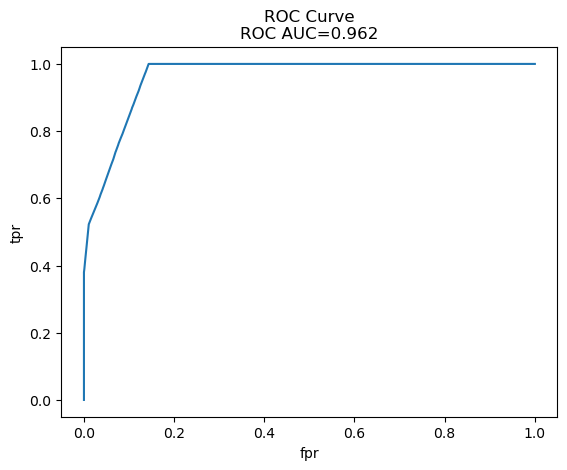

In [40]:
# we see we can have perfect TPR (recall) if we accept a FPR rate of ~ 16.3%
# this corresponds to a decision threshold of ~ 0.81
plt.plot(fpr, tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title(f'ROC Curve\nROC AUC={auc:.3f}');

In [41]:
# decision threshold for elbow
import numpy as np
i = np.where(tpr == 1)[0][0]
tpr[i], fpr[i], t[i]

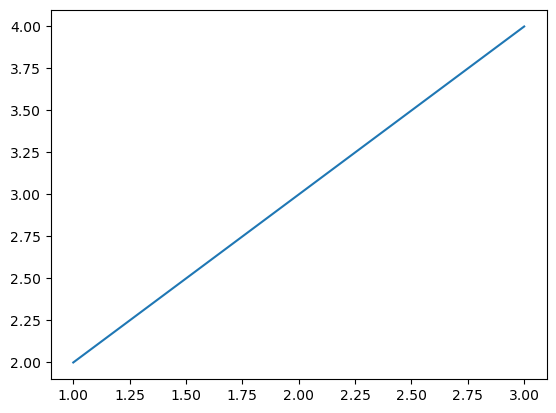

In [42]:
data=pd.DataFrame({'1':[1,3],'2':[2,4]})
plt.plot(data['1'],data['2'])

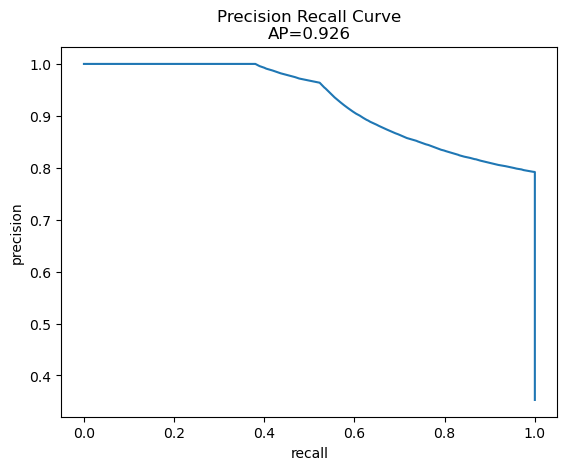

In [43]:
# precion recall curve shows we can acheive percect precision up to a recall of ~.39
plt.plot(r, p)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title(f'Precision Recall Curve\nAP={ave_precision:.3f}');

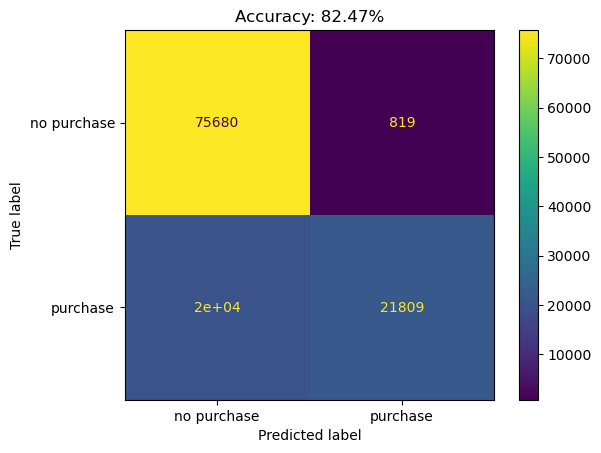

In [44]:
# lets make a confusion matrix using a decision threshold of 0.81
y_pred_t = (y_pred>.81).astype(float)
cnf_matrix = confusion_matrix(y_true, y_pred_t)
ConfusionMatrixDisplay(cnf_matrix, display_labels=['no purchase', 'purchase']).plot()
acc_score = accuracy_score (y_true, y_pred_t)
plt.title(f'Accuracy: {100*acc_score:.2f}%');

In [45]:
# comparing performance of models of ads vs no ad on purchase prediction
scored_sdf_saw_ad = scored_sdf[scored_sdf.SAW_AD==1]
scored_sdf_no_ad = scored_sdf[scored_sdf.SAW_AD!=1]


y_pred_saw_ad = scored_sdf_saw_ad['PREDICTION']
y_true_saw_ad = scored_sdf_saw_ad[target_col]
y_pred_no_ad = scored_sdf_no_ad['PREDICTION']
y_true_no_ad = scored_sdf_no_ad[target_col]

In [46]:
def ap_by_group(df, column):
    tmp = df[df[column]==1]
    y_pred = tmp['PREDICTION']
    y_true = tmp[target_col]
    if y_true.sum() > 0:
        return average_precision_score(y_true, y_pred)
    
# Average Precision by Category
# we see good performance across all subpopulations
for c in scored_sdf.columns[3:-1]:
    print(c, ap_by_group(scored_sdf, c))

IS_CUSTOMER 0.9261488064442787
HOUSEHOLD_INDEX_1 0.9422090842534735
HOUSEHOLD_INDEX_2 0.9383693834895909
HOUSEHOLD_INDEX_3 0.9415029181219136
HOUSEHOLD_INDEX_4 0.9411980204894941
HOUSEHOLD_INDEX_5 0.6613472189013873
HOUSEHOLD_INDEX_6 0.8550840543849878
AGE_BAND_20 None
AGE_BAND_25 None
AGE_BAND_30 None
AGE_BAND_35 0.9238499425487627
AGE_BAND_40 0.9245796939789103
AGE_BAND_45 0.9249457610438993
AGE_BAND_50 None
AGE_BAND_55 None
AGE_BAND_60 None
AGE_BAND_65 None
AGE_BAND_70 None
AGE_BAND_75 None
AGE_BAND_80 None
AGE_BAND_85 None
MARITAL_STATUS_DIVORCED 0.9227694612145181
MARITAL_STATUS_MARRIED 0.9253327948995893
MARITAL_STATUS_SINGLE 0.923847791175681
MARITAL_STATUS_WIDOWED 0.9226207509194467


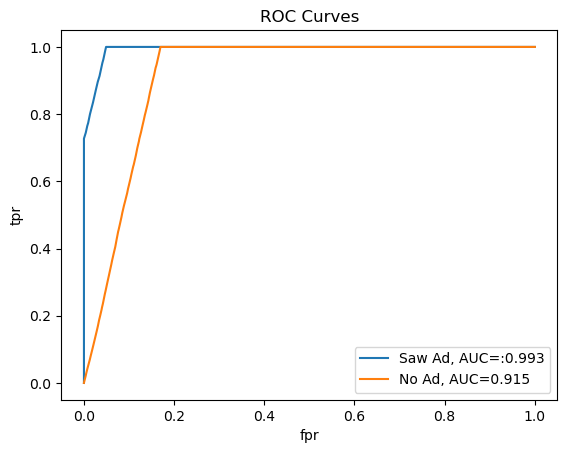

In [47]:
# ROC Curve plots
# our model is more accurate at predicting on the population that has seen ads
fpr, tpr, t = roc_curve(y_true_saw_ad, y_pred_saw_ad)
auc = roc_auc_score(y_true_saw_ad, y_pred_saw_ad)
plt.plot(fpr, tpr, label=f'Saw Ad, AUC=:{auc:.3f}')

fpr, tpr, t = roc_curve(y_true_no_ad, y_pred_no_ad)
auc = roc_auc_score(y_true_no_ad, y_pred_no_ad)
plt.plot(fpr, tpr, label=f'No Ad, AUC={auc:.3f}')
plt.legend()

plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title(f'ROC Curves');

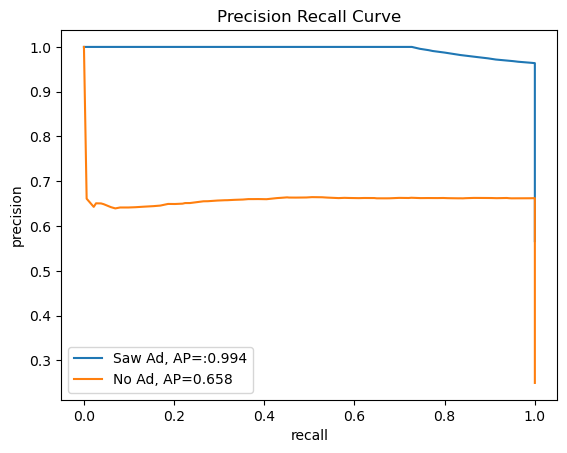

In [48]:
# Precision Recall Curves 
# Again, our model is more accurate at predicting on the population that has seen ads
p, r, c = precision_recall_curve(y_true_saw_ad, y_pred_saw_ad)
ave_precision = average_precision_score(y_true_saw_ad, y_pred_saw_ad)
plt.plot(r, p, label=f'Saw Ad, AP=:{ave_precision:.3f}')

p, r, c = precision_recall_curve(y_true_no_ad, y_pred_no_ad)
ave_precision = average_precision_score(y_true_no_ad, y_pred_no_ad)
plt.plot(r, p, label=f'No Ad, AP={ave_precision:.3f}')
plt.legend()

plt.xlabel('recall')
plt.ylabel('precision')
plt.title(f'Precision Recall Curve');

### Ad Targeting Impact Prediction

In this section, we predict the impact ads have on model output on an individual level (if it would flip an individual's score above our decision threshold) and demonstrate how this could be used for ad targeting.

The intuition is as follows:
- people above our model's decision threshold will likely purchase regardless of ads
- people far below our model's decision threshold will likely not purchase regardless of ads
- people near the model's boundry can be influenced by ads 

Thus, we can select people who's score will flip from below our decision threshold to above it if shown an ad as a population for ad targeting.

In [49]:

tmp = snowpark_df_test.with_column_renamed('SAW_AD', 'SAW_AD_TRUTH')
tmp = tmp.with_column('SAW_AD', lit(0))
tmp = tmp.with_column('NO_AD_SCORE', udf_score_optuna_model_vec_cached(*feature_cols))
tmp = tmp.with_column('SAW_AD', lit(1))
tmp = tmp.with_column('AD_SCORE', udf_score_optuna_model_vec_cached(*feature_cols))
scores = tmp.to_pandas()

In [50]:
df_ad_impact = pd.DataFrame(
    {
        'NO_AD_SCORE': scores.NO_AD_SCORE.values,
        'AD_SCORE': scores.AD_SCORE.values, 
        'SAW_AD': scores.SAW_AD_TRUTH.values,
        'PURCHASED': scores.PURCHASED.values
    }
)

In [51]:
impact= df_ad_impact['AD_SCORE']-df_ad_impact['NO_AD_SCORE']
df_ad_impact['impact']=impact
df_ad_impact=df_ad_impact.sort_values('impact', ascending=False)
df_ad_impact

,NO_AD_SCORE,AD_SCORE,SAW_AD,PURCHASED,impact
107110,0.592369,0.995494,1,1,0.403124
37507,0.592369,0.995494,1,1,0.403124
80921,0.592369,0.995494,1,1,0.403124
80831,0.592369,0.995494,1,1,0.403124
50062,0.592369,0.995494,0,0,0.403124
...,...,...,...,...,...
31223,0.001169,0.000352,1,0,-0.000817
81730,0.001169,0.000352,1,0,-0.000817
15371,0.001169,0.000352,1,0,-0.000817
66439,0.001169,0.000352,1,0,-0.000817


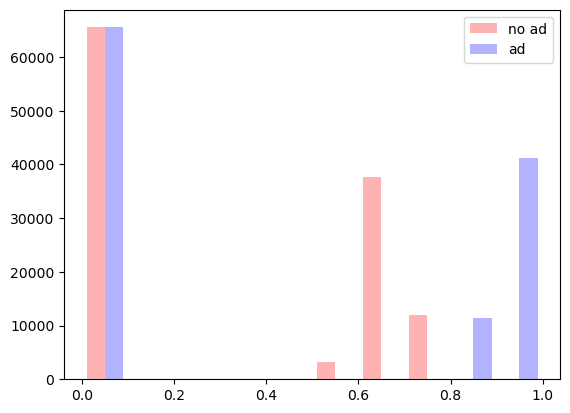

In [52]:
plt.hist([df_ad_impact.NO_AD_SCORE.values,df_ad_impact.AD_SCORE.values], color=['r','b'], label=['no ad', 'ad'],alpha=.3)
plt.legend()

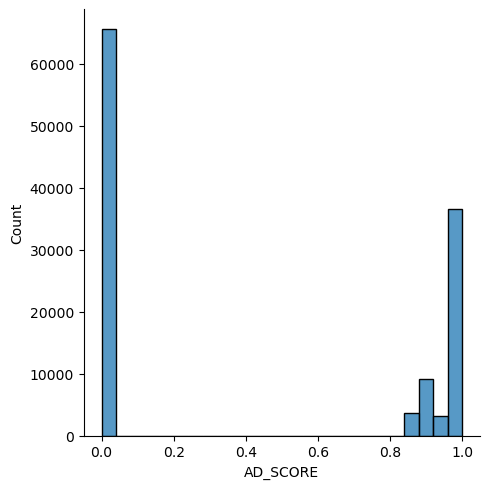

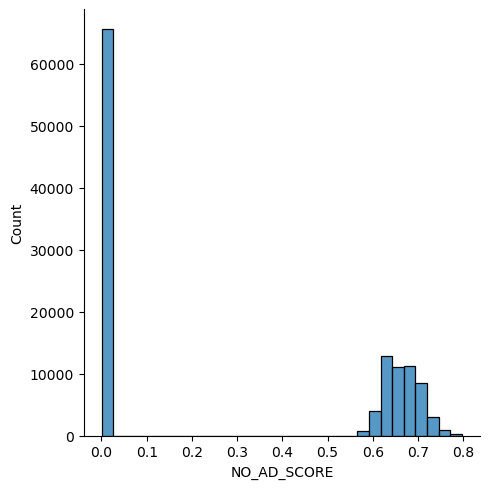

In [53]:
import seaborn as sns
sns.displot(df_ad_impact.AD_SCORE)
sns.displot(df_ad_impact.NO_AD_SCORE)

Average impact of Ads:  0.13520740066675913


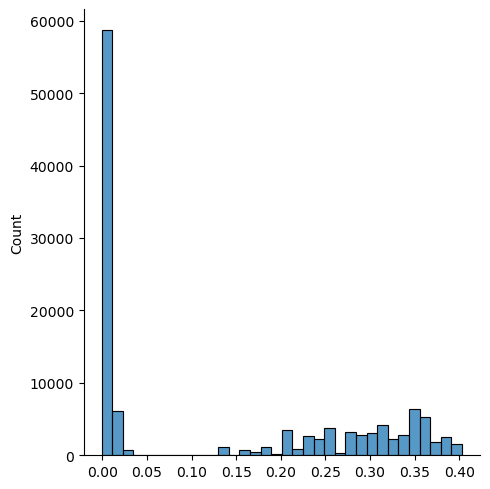

In [54]:
impact= df_ad_impact['AD_SCORE']-df_ad_impact['NO_AD_SCORE']
print('Average impact of Ads: ', impact.mean())
sns.displot(impact)
plt.show()

--- 
## Closeout

    With that we are finished this section of the demo setup

In [56]:
session.close()
print('Finished!!!')

Finished!!!
